In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi_stacking.utils as utils
import sbi_stacking.stacking as stacking
import sbi_stacking.sbibm as ssbibm

In [5]:
device = "cuda:0"
alpha = 0.1
lambd = 1.0

tasks = ["two_moons_whist", "slcp", "sir", "simbig"]

Stacking for task: two_moons_whist
two_moons_whist torch.Size([50, 1000, 2]) torch.Size([50, 1000, 2]) torch.Size([1000, 2]) torch.Size([50, 1000, 2]) torch.Size([50, 1000, 2]) torch.Size([1000, 2])


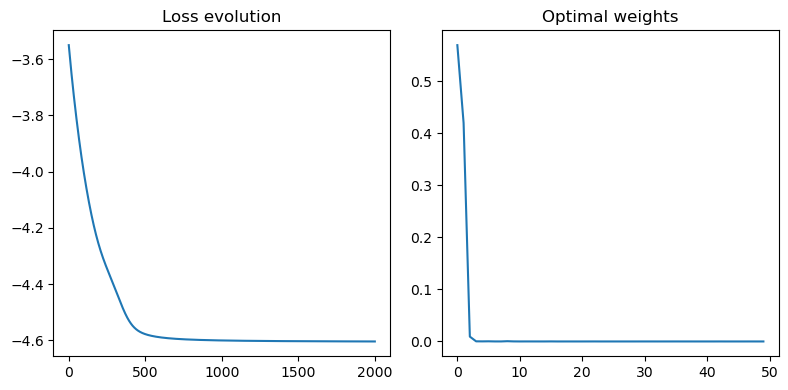

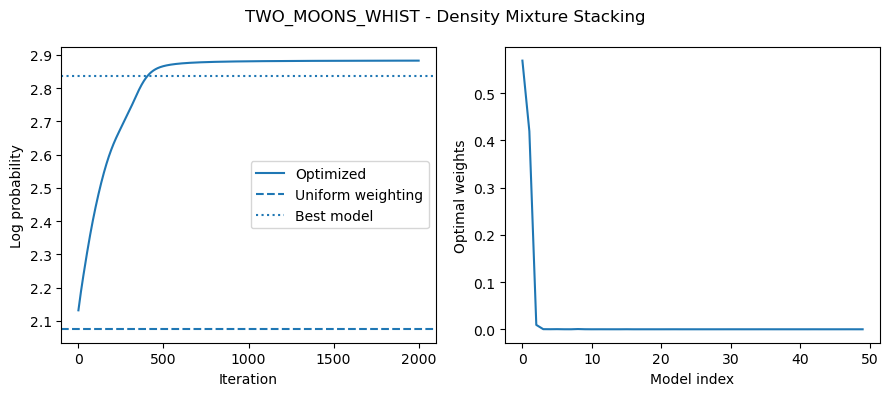

Moments losses: tensor(-1.7156, device='cuda:0') tensor(-1.4102, device='cuda:0') tensor(-1.7263, device='cuda:0')
Best model:  2.8357534408569336
Uniform weighting:  2.07484769821167
Stacked model:  2.8829941749572754
Number of non-negligible weights:  2/50
Stacking for task: slcp
slcp torch.Size([50, 1000, 5]) torch.Size([50, 1000, 5]) torch.Size([1000, 5]) torch.Size([50, 1000, 5]) torch.Size([50, 1000, 5]) torch.Size([1000, 5])


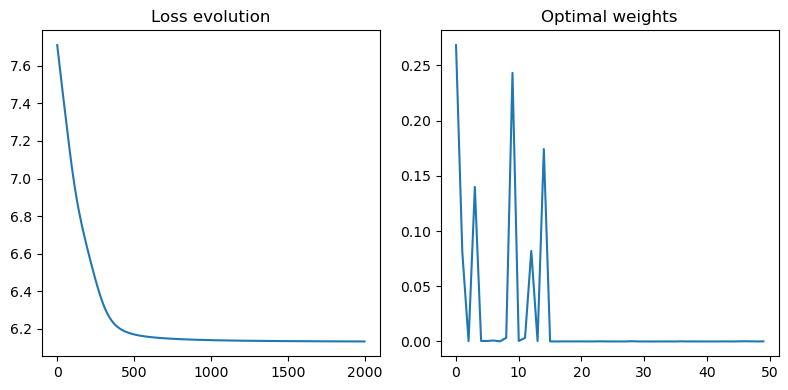

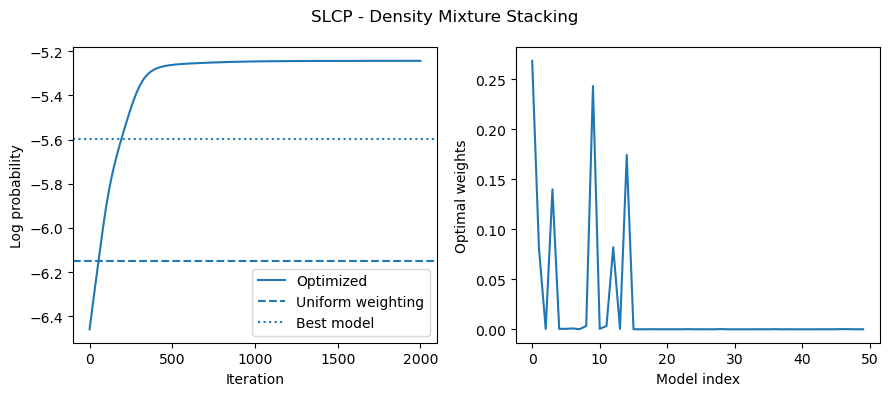

Moments losses: tensor(1.0319, device='cuda:0') tensor(1.2497, device='cuda:0') tensor(0.9479, device='cuda:0')
Best model:  -5.597587585449219
Uniform weighting:  -6.1508026123046875
Stacked model:  -5.243074417114258
Number of non-negligible weights:  6/50
Stacking for task: sir
sir torch.Size([50, 1000, 2]) torch.Size([50, 1000, 2]) torch.Size([1000, 2]) torch.Size([50, 1000, 2]) torch.Size([50, 1000, 2]) torch.Size([1000, 2])


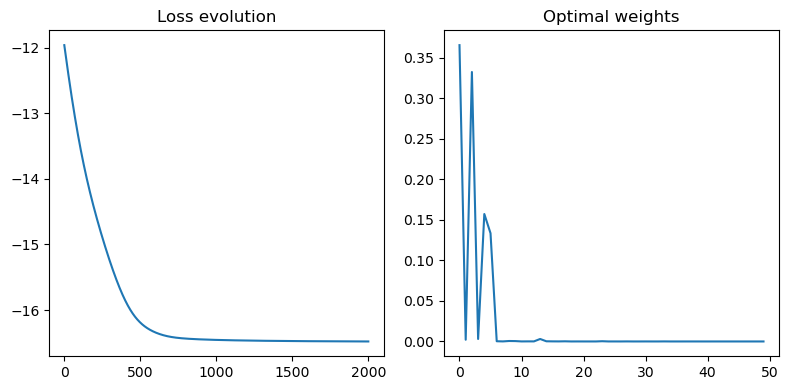

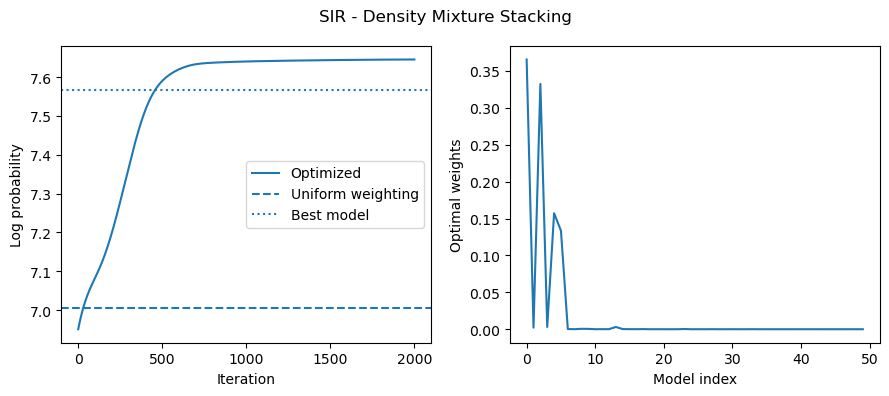

Moments losses: tensor(-8.8563, device='cuda:0') tensor(-5.1943, device='cuda:0') tensor(-8.9103, device='cuda:0')
Best model:  7.566440105438232
Uniform weighting:  7.00565767288208
Stacked model:  7.64520263671875
Number of non-negligible weights:  4/50
Stacking for task: simbig
simbig torch.Size([100, 1000, 14]) torch.Size([100, 1000, 14]) torch.Size([1000, 14]) torch.Size([100, 1000, 14]) torch.Size([100, 1000, 14]) torch.Size([1000, 14])


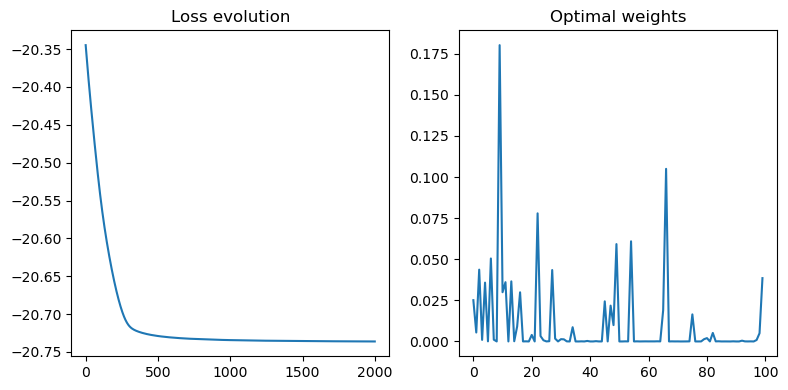

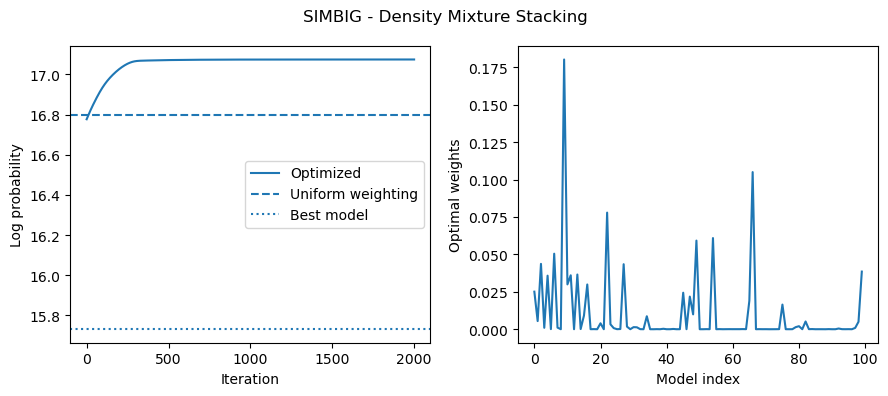

Moments losses: tensor(-3.6819, device='cuda:0') tensor(-3.7439, device='cuda:0') tensor(-3.8071, device='cuda:0')
Best model:  15.730704307556152
Uniform weighting:  16.799238204956055
Stacked model:  17.07464027404785
Number of non-negligible weights:  19/100


In [6]:
for task in tasks:
    print("Stacking for task:", task)

    if task != "simbig":
        means_train = utils.get_stats(task, "means") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds_train = utils.get_stats(task, "stds") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas_train = utils.get_stats(task, "theta_test") # shape (nb_simulations, 2) -> theta_n in the paper

        means_test = utils.get_stats(task, "means_v2") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds_test = utils.get_stats(task, "stds_v2") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas_test = utils.get_stats(task, "theta_test_v2") # shape (nb_simulations, 2) -> theta_n in the paper

        log_probs_train = utils.get_stats(task, "log_probs")
        log_probs_test = utils.get_stats(task, "log_probs_v2")

    else:
        means = utils.get_stats(task, "means") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds = utils.get_stats(task, "stds") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas = utils.get_stats(task, "theta_test") # shape (nb_simulations, 2) -> theta_n in the paper
        log_probs = utils.get_stats(task, "log_probs")

        randindices = torch.randperm(means.shape[1])

        means_train = means[:, randindices[:1000]]
        stds_train = stds[:, randindices[:1000]]
        thetas_train = thetas[randindices[:1000]]
        means_test = means[:, randindices[1000:]]
        stds_test = stds[:, randindices[1000:]]
        thetas_test = thetas[randindices[1000:]]

        log_probs_train = log_probs[:, randindices[:1000]]
        log_probs_test = log_probs[:, randindices[1000:]]

    print(task, means_train.shape, stds_train.shape, thetas_train.shape, means_test.shape, stds_test.shape, thetas_test.shape)
    nb_models = means_train.shape[0]

    opt_weights, losses, weights_evol = stacking.stacking_hybrid_log_prob_moments(log_probs_train, means_train, stds_train, thetas_train, lambd=lambd)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].plot(losses)
    axs[0].set_title("Loss evolution")
    axs[1].plot(opt_weights.cpu())
    axs[1].set_title("Optimal weights")
    plt.tight_layout()
    plt.show()

    # Compute evolution of log probs
    log_probs_evol = np.zeros(weights_evol.shape[0])
    for i in range(weights_evol.shape[0]):
        weights = weights_evol[i]
        log_probs_evol[i] = stacking.ensemble_log_prob(log_probs_test, weights).mean().item()

    # Compute log_probs for uniform weights
    uniform_weights = torch.ones(nb_models, device=device) / nb_models
    log_prob_unif = stacking.ensemble_log_prob(log_probs_test, uniform_weights).mean().item()

    # Plot of the evolution of the log probabilities and optimal weights
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    axs[0].plot(log_probs_evol, label='Optimized', color='C0')
    axs[0].axhline(log_prob_unif, label='Uniform weighting', color='C0', linestyle='--')
    axs[0].axhline(log_probs_test[0].mean().item(), label='Best model', color='C0', linestyle=':')
    axs[0].legend()
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Log probability')
    axs[1].plot(opt_weights.cpu().numpy())
    axs[1].set_xlabel('Model index')
    axs[1].set_ylabel('Optimal weights')
    plt.suptitle(f'{task.upper()} - Density Mixture Stacking')
    plt.tight_layout()
    plt.show()

    l_stacked = stacking.moments_loss(means_test, stds_test, thetas_test, torch.log(opt_weights))
    l_unif = stacking.moments_loss(means_test, stds_test, thetas_test, torch.ones(nb_models, device=device)/nb_models)
    weights_best_model = torch.zeros(nb_models, device=device)
    weights_best_model[0] = 1e9
    l_best = stacking.moments_loss(means_test, stds_test, thetas_test, weights_best_model)

    print("Moments losses:", l_best, l_unif, l_stacked)
    print("Best model: ", log_probs_test[0].mean().item())
    print("Uniform weighting: ", log_prob_unif)
    print("Stacked model: ", log_probs_evol[-1])
    print("Number of non-negligible weights: ", f"{(opt_weights > 0.01).sum().item()}/{nb_models}")